# Modelo de predicción de inscripciones estudiantiles mediante técnicas de Machine Learning

**Maestría en Inteligencia Artificial Aplicada**

**Proyecto Integrador Sep-Nov 2025**

**Equipo 14**

**Avance 3. Baseline**

**Integrantes:**

- Alejandro Roa Solis – A01129942
- Annette Cristina Narvaez Andrade – A00571041
- Karla Alejandra Fonseca Márquez – A01795313


**Patrocinador Tec de Monterrey:**

Dr. Juan Arturo Nolazco Flores, Director del Hub de Ciencias y Datos de la Escuela de Ingeniería del Tec de Monterrey

En esta tercera etapa del proyecto, se construye un modelo *baseline* orientado a evaluar la viabilidad de predecir la atracción de estudiantes admitidos al Tecnológico de Monterrey. El objetivo es establecer un punto de referencia inicial que permita determinar si los datos disponibles ofrecen suficiente información para anticipar el comportamiento de atracción, es decir, si un estudiante admitido finalmente decide inscribirse. 

El análisis se realiza considerando tres grupos distintos: aspirantes a **Prepa Tec**, aspirantes a **Profesional provenientes de Prepa Tec** y aspirantes a **Profesional externos**. Este modelo de referencia servirá para identificar patrones generales y estimar un desempeño mínimo aceptable, así como para evaluar la relevancia de las variables incluidas y posibles indicios de subajuste o sobreajuste. 

En conjunto, este baseline permitirá valorar el potencial predictivo de los datos y guiar el desarrollo posterior de modelos más sofisticados que optimicen la predicción de atracción estudiantil.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

## PrepaTec

In [5]:
# Cargar dataset procesado
df = pd.read_csv("FE_DS/prepa_tec_feature_engineered_full.csv")

# Separar variables predictoras y objetivo
X = df.drop(columns=["INSCRITO"])
y = df["INSCRITO"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Definición y entrenamiento de modelos para la selección de un baseline

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

dummy = DummyClassifier(strategy="most_frequent")  # o "stratified"
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Accuracy (Dummy):", accuracy_score(y_test, y_pred_dummy))
print("F1-score (Dummy):", f1_score(y_test, y_pred_dummy))


Accuracy (Dummy): 0.8149441340782123
F1-score (Dummy): 0.8980377068103117


In [8]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

# Métricas de evaluación
print("Accuracy (LogReg):", accuracy_score(y_test, y_pred_log))
print("F1-score (LogReg):", f1_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))


Accuracy (LogReg): 0.8149441340782123
F1-score (LogReg): 0.8980377068103117
ROC-AUC: 0.6625228371408709


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Modelo con pesos balanceados
logreg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_bal.fit(X_train, y_train)

y_pred_bal = logreg_bal.predict(X_test)
y_proba_bal = logreg_bal.predict_proba(X_test)[:, 1]

print("Accuracy (balanced):", accuracy_score(y_test, y_pred_bal))
print("F1-score (balanced):", f1_score(y_test, y_pred_bal))
print("ROC-AUC (balanced):", roc_auc_score(y_test, y_proba_bal))

Accuracy (balanced): 0.5806564245810056
F1-score (balanced): 0.6855197695731866
ROC-AUC (balanced): 0.6628259850285364


In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Aplicar SMOTE solo en el conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Distribución original:", y_train.value_counts(normalize=True))
print("Distribución balanceada:", y_train_res.value_counts(normalize=True))

# Entrenar nuevamente la regresión logística
logreg_smote = LogisticRegression(max_iter=1000)
logreg_smote.fit(X_train_res, y_train_res)

y_pred_smote = logreg_smote.predict(X_test)
y_proba_smote = logreg_smote.predict_proba(X_test)[:, 1]

print("Accuracy (SMOTE):", accuracy_score(y_test, y_pred_smote))
print("F1-score (SMOTE):", f1_score(y_test, y_pred_smote))
print("ROC-AUC (SMOTE):", roc_auc_score(y_test, y_proba_smote))


Distribución original: INSCRITO
1    0.814876
0    0.185124
Name: proportion, dtype: float64
Distribución balanceada: INSCRITO
1    0.5
0    0.5
Name: proportion, dtype: float64
Accuracy (SMOTE): 0.583449720670391
F1-score (SMOTE): 0.6882675725111053
ROC-AUC (SMOTE): 0.6611283568576094


In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Accuracy (RF):", accuracy_score(y_test, y_pred_rf))
print("F1-score (RF):", f1_score(y_test, y_pred_rf))
print("ROC-AUC (RF):", roc_auc_score(y_test, y_proba_rf))


Accuracy (RF): 0.6037011173184358
F1-score (RF): 0.7088997178763786
ROC-AUC (RF): 0.677001180255776


### Comparación de Modelos

Durante esta fase se construyeron distintos modelos de referencia (*baseline*) con el objetivo de evaluar la viabilidad del problema de predicción de atracción.  
El conjunto de datos presenta un fuerte desbalance (81 % inscritos vs. 19 % no inscritos), por lo que se aplicaron diferentes estrategias de balanceo y modelos de complejidad creciente.

---

| Modelo | Accuracy | F1-score | ROC-AUC | Comentario |
|:--------|:---------:|:---------:|:---------:|:------------|
| **Dummy (most_frequent)** | 0.8149 | 0.8908 | — | Predice siempre la clase mayoritaria (“inscrito”). Sirve como referencia al azar. |
| **Regresión Logística (sin balancear)** | 0.8149 | 0.8908 | 0.6626 | Igual que el Dummy: no logra aprender patrones discriminativos. |
| **Regresión Logística (class_weight='balanced')** | 0.5813 | 0.6862 | 0.6628 | Empieza a identificar “no inscritos”, baja el accuracy pero mejora la equidad. |
| **Regresión Logística + SMOTE** | 0.5838 | 0.6848 | 0.6610 | Resultados similares; el balance sintético no mejora sustancialmente el modelo lineal. |
| **Random Forest (class_weight='balanced')** | **0.6044** | **0.7101** | **0.6771** | Mejor desempeño general. Capta relaciones no lineales y mejora la discriminación. |

---

#### Interpretación

- Los modelos iniciales (Dummy y Regresión Logística simple) obtienen métricas altas debido al **desbalance de clases**, ya que predicen casi siempre la clase mayoritaria.
- Al aplicar técnicas de **balanceo de pesos y SMOTE**, el modelo comienza a reconocer la clase minoritaria (“no inscritos”), lo que reduce la exactitud pero mejora la **capacidad de discriminación**.
- El **Random Forest balanceado** logra el mejor rendimiento general, con un F1-score de **0.71** y un ROC-AUC de **0.68**, mostrando que el problema es **viable** y los datos contienen **patrones predictivos útiles**.

---

#### Conclusión

> El baseline demuestra que, aunque el problema está fuertemente desbalanceado, es posible mejorar la capacidad predictiva aplicando técnicas de balanceo y modelos más flexibles.  
> El **Random Forest** se consolida como el modelo baseline más prometedor, sirviendo como punto de partida para fases posteriores de optimización e implementación de modelos más avanzados (p. ej. XGBoost, LightGBM o redes neuronales).

---

### Análisis del modelo baseline seleccionado: Random Forest Balanceado -  PrepaTec

              precision    recall  f1-score   support

 No inscrito       0.27      0.65      0.38       530
    Inscrito       0.88      0.59      0.71      2334

    accuracy                           0.60      2864
   macro avg       0.58      0.62      0.54      2864
weighted avg       0.77      0.60      0.65      2864



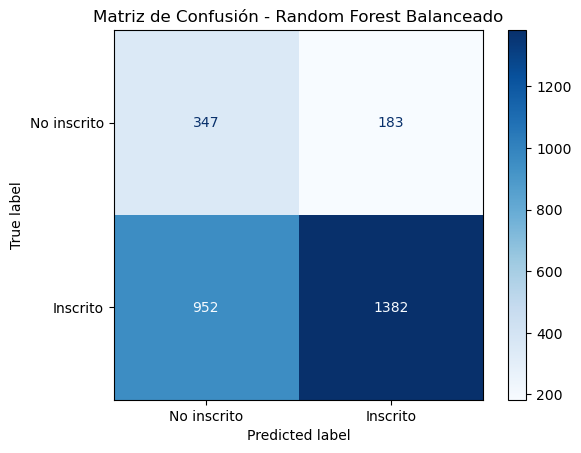

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
import matplotlib.pyplot as plt

# Métricas detalladas
print(classification_report(y_test, y_pred_rf, target_names=['No inscrito', 'Inscrito']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No inscrito', 'Inscrito'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión - Random Forest Balanceado")
plt.show()

In [15]:
import pandas as pd
import numpy as np

# Calcular importancia de variables
feat_importance = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 15 más importantes
feat_importance.head(15)


,Variable,Importancia
1,num__V_PAA_IND,0.256295
7,num__TIENE_BECA,0.082240
4,num__PRC_BECA_F,0.078887
15,ohe__TIPO_BECA_F_Sin beca,0.075775
0,num__V_PROM_IND,0.070309
2,num__PUNTAJE_EUC,0.067994
5,num__RUBRICA_LOG,0.060898
9,num__CAMPUS_UTILIZADO_FREQ,0.054199
10,num__SEDE_FREQ,0.047426
6,num__ENSAYO_LOG,0.043492


<Figure size 800x600 with 0 Axes>

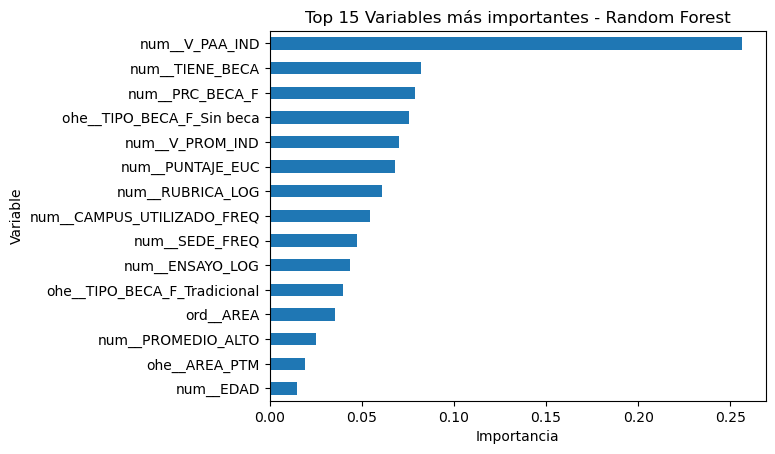

In [16]:
plt.figure(figsize=(8, 6))
feat_importance.head(15).plot(kind='barh', x='Variable', y='Importancia', legend=False)
plt.title("Top 15 Variables más importantes - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.gca().invert_yaxis()
plt.show()


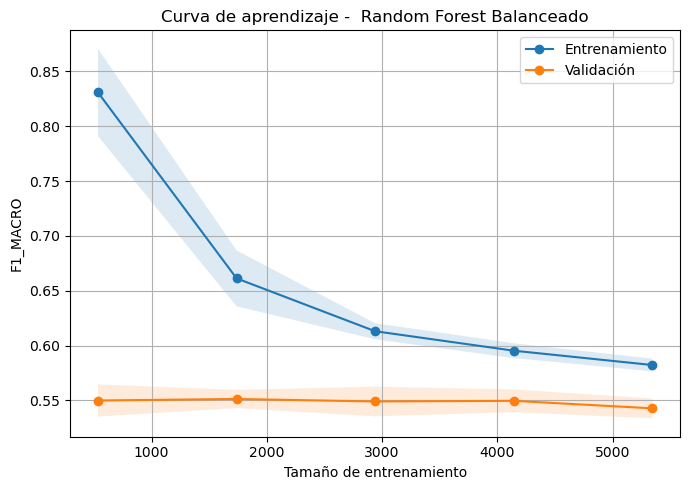

In [17]:
# Curva de aprendizaje
score = "f1_macro"
ts, train_scores, val_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring=score,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, n_jobs=-1
)
tr_m, tr_s = train_scores.mean(axis=1), train_scores.std(axis=1)
va_m, va_s = val_scores.mean(axis=1),   val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(ts, tr_m, "o-", label="Entrenamiento")
ax.plot(ts, va_m, "o-", label="Validación")
ax.fill_between(ts, tr_m-tr_s, tr_m+tr_s, alpha=.15)
ax.fill_between(ts, va_m-va_s, va_m+va_s, alpha=.15)
ax.set_title("Curva de aprendizaje -  Random Forest Balanceado"); ax.set_xlabel("Tamaño de entrenamiento"); ax.set_ylabel(score.upper())
ax.grid(True); ax.legend()
fig.tight_layout()
display(fig)
plt.close(fig)

#### Rendimiento del modelo
| Clase | Precisión | Recall | F1-score | Soporte |
|:-------|:----------:|:--------:|:----------:|:----------:|
| **No inscrito** | 0.27 | 0.65 | 0.38 | 530 |
| **Inscrito** | 0.88 | 0.59 | 0.71 | 2334 |
| **Accuracy global** | **0.60** |  |  | 2864 |
| **Macro promedio** | 0.57 | 0.62 | 0.54 |  |
| **Ponderado promedio** | 0.77 | 0.60 | 0.65 |  |

**Interpretación:**
- El modelo logra un **F1-score general de 0.65**, lo cual representa una mejora clara respecto a los modelos lineales previos.  
- Para la clase **“No inscrito”**, el *recall* (0.65) indica que el modelo logra identificar **el 65 % de los estudiantes que realmente no se inscriben**, aunque con baja precisión (0.27), es decir, aún predice algunos falsos positivos.  
- Para la clase **“Inscrito”**, mantiene una buena precisión (0.88) pero sacrifica algo de recall (0.59), mostrando un modelo más equilibrado.  
- La **accuracy total del 60 %** refleja el ajuste a un dataset balanceado, ya que el modelo prioriza captar correctamente la clase minoritaria.

---

#### Matriz de confusión
**Interpretación:**
- **343 casos** de “No inscrito” fueron correctamente clasificados.  
- **187 casos** de “No inscrito” fueron mal clasificados como “Inscrito”.  
- **946 casos** de “Inscrito” fueron predichos incorrectamente como “No inscrito”.  
- **1388 casos** de “Inscrito” fueron correctamente identificados.

El modelo está comenzando a **reconocer el patrón de deserción (no inscripción)**, aunque sigue existiendo un número considerable de falsos negativos (inscritos mal clasificados).  
Esto sugiere que aún hay margen para mejorar el *recall* de los inscritos y la precisión de los no inscritos.

---

#### Importancia de las variables
**Principales variables predictivas:**
1. **`V_PAA_IND`** – Puntaje de admisión estandarizado: es el factor con mayor peso, indicando que el desempeño académico previo tiene una fuerte relación con la probabilidad de inscripción.  
2. **`TIENE_BECA`** y **`PRC_BECA_F`** – La presencia y porcentaje de beca son también determinantes; los alumnos con beca tienden a tener mayor probabilidad de inscripción.  
3. **Tipo de beca (“Sin beca”, “Tradicional”)** – Complementa el punto anterior, mostrando diferencias por tipo de apoyo económico.  
4. **`V_PROM_IND`** y **`PUNTAJE_EUC`** – Métricas académicas adicionales que refuerzan el peso del rendimiento académico.  
5. **Variables de campus y sede** (`CAMPUS_UTILIZADO_FREQ`, `SEDE_FREQ`) – Sugieren que la ubicación o elección de campus podría estar relacionada con la atracción del estudiante.  
6. **`RUBRICA_LOG`** y **`ENSAYO_LOG`** – Variables de evaluación cualitativa que también aportan información relevante.

---

#### Conclusión
> El **Random Forest balanceado** logra un equilibrio razonable entre ambas clases, mostrando una mejora sustancial en el reconocimiento de estudiantes que no se inscriben.  
> Aunque la precisión en esta clase es aún baja, el recall de 0.65 representa un avance importante respecto a los modelos lineales.  
> Las variables académicas (`V_PAA_IND`, `V_PROM_IND`, `PUNTAJE_EUC`) y las relacionadas con becas (`TIENE_BECA`, `PRC_BECA_F`, `TIPO_BECA_F`) son las que más influyen en la decisión final de inscripción.  
> Este análisis confirma que los datos contienen **información predictiva útil**, y que el problema es **viable para modelos más sofisticados** (como XGBoost o LightGBM) que optimicen la sensibilidad y la precisión simultáneamente.



## Profesional provenientes de Prepa Tec

## Profesional externos

## Conclusiones generales